In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_wavelength_at_max(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for tag, y in zip(f['/bunches'], arr):
                yield {"tag": tag, "atmax": x[np.argmax(y)]}
        except KeyError:
            return


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            return

In [3]:
run = 66
filenames = sorted(fn for fn in set(iglob(f"/data/TwoPulses/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
bg_period, bg_mod = 3, 0  # /Background_Period

integ = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod
integ

,tag,tof,is_bg
npartitions=100,,,
,int64,object,bool
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [4]:
with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed | 59.2s


,count,summed
is_bg,,
True,9991,"[4415620.0, 4415780.0, 4415788.0, 4415783.0, 4..."
False,19982,"[8831588.0, 8831509.0, 8831559.0, 8831533.0, 8..."


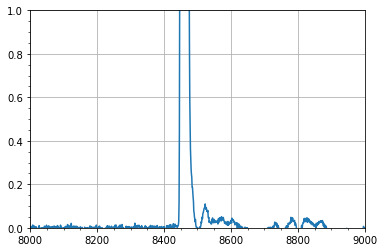

In [5]:
avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 9000)
plt.ylim(0, 1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [6]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            _, n = f["/photon_diagnostics/Spectrometer/hor_spectrum"].shape
            x = a * (np.arange(n) - x0) + x1

            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8400:8500].sum(),
                         'delay': round(dt, 2),
                         'atmax': x[np.argmax(hor)]}
                        for tag, iom, tof, dt, hor
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position'],
                               f["/photon_diagnostics/Spectrometer/hor_spectrum"]))
        except KeyError:
            return


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    )
df = df.set_index("tag").sort_index()
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1min 16.9s


,atmax,delay,iom_intensity_pc,tof_intensity
tag,,,,
478520693,50.694484,-5.92,366.915894,43273
478520694,50.696898,-5.92,399.006271,44218
478520695,50.694484,-5.92,350.990868,43313
478520696,50.682416,-5.92,340.967560,43860
478520697,50.696898,-5.92,380.942345,44209
478520698,50.696898,-5.92,416.869354,42428
478520699,50.689657,-5.92,364.275742,43522
478520700,50.696898,-5.92,330.928802,44206
478520701,50.692070,-5.92,358.255577,43444


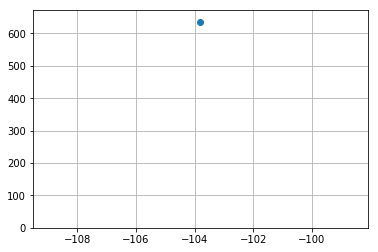

In [7]:
df['is_bg'] = df.index % bg_period == bg_mod
df["phi"] = 1239.84193 / df["atmax"] % 0.0158 / 0.0158 * 2 * np.pi
df["binned"] = df["phi"].apply(np.digitize, bins=np.linspace(0, 2 * np.pi, 12+1))
groupped = df.groupby(['delay', 'binned', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
# plt.figure()
diff = -(
    (groupped.loc[pd.IndexSlice[:, :, False], 'sum'] 
        / groupped.loc[pd.IndexSlice[:, :, False], 'count'])
        .reset_index(level=[2], drop=True)
    - (groupped.loc[pd.IndexSlice[:, :, True], 'sum']
        / groupped.loc[pd.IndexSlice[:, :, True], 'count'])
        .reset_index(level=[2], drop=True)
)[:, 1]
plt.plot((diff.index - 1) / 24 * 360, diff, 'o-')
plt.ylim(0, None)
plt.grid(True)
plt.show()

In [8]:
groupped

count        sum
delay binned is_bg                  
-5.92 1      False   2843  123833647
             True    1492   65936842
      2      False   2673  116696591
             True    1357   59970325
      3      False   1841   80515702
             True     914   40392766
      4      False   1643   72022420
             True     796   35177831
      5      False    943   41389938
             True     420   18561269
      6      False    646   28347554
             True     294   12993049
      7      False    451   19708505
             True     210    9280920
      8      False    489   21204436
             True     228   10076005
      9      False    631   27188993
             True     380   16793195
      10     False   1092   47031567
             True     563   24880154
      11     False   1675   72282936
             True     804   35530841
      12     False   5055  219269555
             True    2533  111940262